In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, 
    matthews_corrcoef, 
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score, 
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay
)

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

import scienceplots
plt.style.use(['science', 'no-latex'])

## Load Dataset

In [3]:
df_train = pd.read_parquet("../dataset/merged/train.parquet")
df_test = pd.read_parquet("../dataset/merged/test.parquet")

In [4]:
cols_exclude_sel = [x for x in df_train.columns.tolist() if "_sum" in x]
cols_non_features = ["ts", "zone_id", "country", "target", ""]
cols_exclude = cols_exclude_sel + cols_non_features

X_train, y_train = df_train.drop(columns=cols_exclude, errors="ignore"), df_train["target"]
X_test, y_test = df_test.drop(columns=cols_exclude, errors="ignore"), df_test["target"]

In [6]:
n_neg = y_train[y_train == 0].shape[0]
n_pos = y_train[y_train == 1].shape[0]

n_neg/n_pos

82.52327845052298

## Feature Importance

In [7]:
clf = XGBClassifier(random_state=42, max_depth=10, n_estimators=100, scale_pos_weight=n_neg/n_pos)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

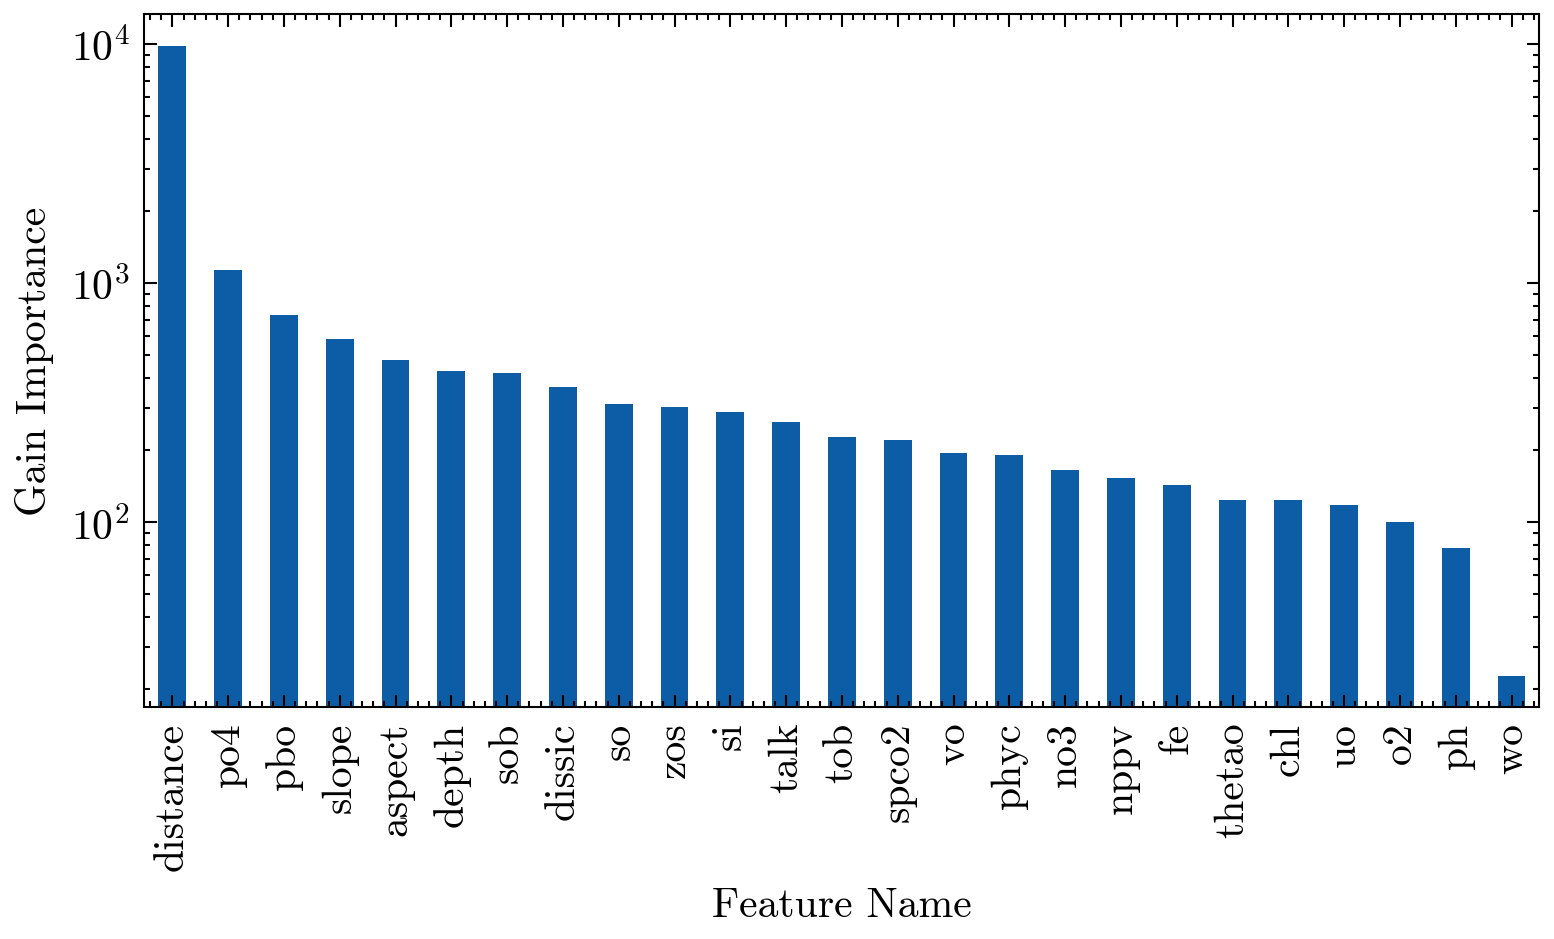

In [ ]:
importance = pd.Series(clf.get_booster().get_score(importance_type="gain"))
importance.index = [x.replace("_mean", "").replace("bathy", "depth") for x in importance.index]
importance.to_csv("../dataset/xgboost-gain.csv")

fig, ax = plt.subplots(figsize=(6, 3))
importance.sort_values(ascending=False).plot.bar(logy=True, ax=ax)
ax.set_xlabel("Feature Name")
ax.set_ylabel("Gain Importance")

fig.savefig("FIG-11.jpg")
fig.savefig("FIG-11.pdf")
plt.show()

In [13]:
df_importance = pd.read_csv("../dataset/xgboost-gain.csv", names=["variable_name", "value"], skiprows=1).sort_values("value", ascending=False)
df_importance.head()

,variable_name,value
14,distance,9807.446289
9,po4,1137.495850
6,pbo,731.434082
23,slope,585.046570
2,aspect,474.804138


## Cross Validation

In [18]:
def cross_val_custom(X, y):
    print(f"Feature count: {X.shape[1]}")
    print(X.columns)
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for fold_i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        print(f"Training fold {fold_i + 1}")

        # split data
        X_cv_train, X_cv_test = X.iloc[train_idx], X.iloc[test_idx]
        y_cv_train, y_cv_test = y.iloc[train_idx], y.iloc[test_idx]

        clf = XGBClassifier(random_state=42, max_depth=10, n_estimators=100, scale_pos_weight=n_neg/n_pos)

        # fit model
        st_train = time.time()
        clf.fit(X_cv_train, y_cv_train)
        dt_train = time.time() - st_train

        # predict
        st_test = time.time()
        y_pred = clf.predict(X_cv_test)
        dt_test = time.time() - st_test

        # eval
        yield {
            "feature_count": X.shape[1],
            "fold": fold_i + 1,

            "accuracy": accuracy_score(y_cv_test, y_pred),
            "precision": precision_score(y_cv_test, y_pred),
            "recall": recall_score(y_cv_test, y_pred),
            "f1": f1_score(y_cv_test, y_pred),
            "mcc": matthews_corrcoef(y_cv_test, y_pred),
            "roc_auc": roc_auc_score(y_cv_test, y_pred),
            "ap": average_precision_score(y_cv_test, y_pred),
            
            "training_duration": dt_train,
            "inference_duration": dt_test,
        }

In [23]:
scores = [
    *cross_val_custom(df_train[df_importance.iloc[:25]["variable_name"].tolist()], df_train["target"]),
    *cross_val_custom(df_train[df_importance.iloc[:20]["variable_name"].tolist()], df_train["target"]),
    *cross_val_custom(df_train[df_importance.iloc[:15]["variable_name"].tolist()], df_train["target"]),
    *cross_val_custom(df_train[df_importance.iloc[:10]["variable_name"].tolist()], df_train["target"]),
    *cross_val_custom(df_train[df_importance.iloc[:5]["variable_name"].tolist()], df_train["target"]),
    *cross_val_custom(df_train[df_importance.iloc[:4]["variable_name"].tolist()], df_train["target"]),
    *cross_val_custom(df_train[df_importance.iloc[:3]["variable_name"].tolist()], df_train["target"]),
    *cross_val_custom(df_train[df_importance.iloc[:2]["variable_name"].tolist()], df_train["target"]),
    *cross_val_custom(df_train[df_importance.iloc[:1]["variable_name"].tolist()], df_train["target"]),
]

df_scores = pd.DataFrame(scores)
df_scores.to_csv("cross-val-feature-selection.csv")
df_scores.head()

Feature count: 25
Index(['distance', 'po4', 'pbo', 'slope', 'aspect', 'depth', 'sob', 'dissic',
       'so', 'zos', 'si', 'talk', 'tob', 'spco2', 'vo', 'phyc', 'no3', 'nppv',
       'fe', 'thetao', 'chl', 'uo', 'o2', 'ph', 'wo'],
      dtype='object')
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Training fold 6
Training fold 7
Training fold 8
Training fold 9
Training fold 10
Feature count: 20
Index(['distance', 'po4', 'pbo', 'slope', 'aspect', 'depth', 'sob', 'dissic',
       'so', 'zos', 'si', 'talk', 'tob', 'spco2', 'vo', 'phyc', 'no3', 'nppv',
       'fe', 'thetao'],
      dtype='object')
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Training fold 6
Training fold 7
Training fold 8
Training fold 9
Training fold 10
Feature count: 15
Index(['distance', 'po4', 'pbo', 'slope', 'aspect', 'depth', 'sob', 'dissic',
       'so', 'zos', 'si', 'talk', 'tob', 'spco2', 'vo'],
      dtype='object')
Training fold 1
Training fold 

,feature_count,fold,accuracy,precision,recall,f1,mcc,roc_auc,ap,training_duration,inference_duration
0,25,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.592665,0.086898
1,25,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.406289,0.105340
2,25,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.438944,0.112219
3,25,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.059823,0.086321
4,25,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.452822,0.091441


## Training and Evaluation

In [30]:
def train_eval(top_n):
    print(f"Eval: {top_n}")
    X_train, y_train = df_train[df_importance.iloc[:top_n]["variable_name"].tolist()], df_train["target"]
    X_test, y_test = df_test[df_importance.iloc[:top_n]["variable_name"].tolist()], df_test["target"]

    clf = XGBClassifier(random_state=42, max_depth=10, n_estimators=100, scale_pos_weight=n_neg/n_pos)

    st = time.time()
    clf.fit(X_train, y_train)
    dt_train = time.time() - st

    st = time.time()
    y_pred = clf.predict(X_test)
    dt_test = time.time() - st

    yield {
        "feature_count": X_train.shape[1],

        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "mcc": matthews_corrcoef(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred),
        "ap": average_precision_score(y_test, y_pred),
        
        "training_duration": dt_train,
        "inference_duration": dt_test,
    }

In [31]:
scores_eval = [
    *train_eval(25),
    *train_eval(20),
    *train_eval(15),
    *train_eval(10),
    *train_eval(5),
    *train_eval(4),
    *train_eval(3),
    *train_eval(2),
    *train_eval(1),
]

df_scores_eval = pd.DataFrame(scores_eval)
df_scores_eval.to_csv("eval-feature-selection.csv")
df_scores_eval.head()

Eval: 25
Eval: 20
Eval: 15
Eval: 10
Eval: 5
Eval: 4
Eval: 3
Eval: 2
Eval: 1


,feature_count,accuracy,precision,recall,f1,mcc,roc_auc,ap,training_duration,inference_duration
0,25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.622298,0.225229
1,20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.829026,0.209910
2,15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,12.139730,0.190748
3,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.329009,0.181939
4,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.052931,0.178350


In [33]:
df_scores_eval.round(5)

,feature_count,accuracy,precision,recall,f1,mcc,roc_auc,ap,training_duration,inference_duration
0,25,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,11.62230,0.22523
1,20,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,10.82903,0.20991
2,15,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,12.13973,0.19075
3,10,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,8.32901,0.18194
4,5,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,7.05293,0.17835
5,4,0.99985,0.98839,0.99960,0.99396,0.99391,0.99973,0.98800,6.66456,0.18540
6,3,0.98319,0.41501,0.98667,0.58427,0.63429,0.98491,0.40964,10.14293,0.17184
7,2,0.92722,0.14019,0.98931,0.24558,0.35812,0.95789,0.13882,9.24151,0.18888
8,1,0.85559,0.07656,1.00000,0.14223,0.25568,0.92692,0.07656,3.80685,0.08928
